<h3>Classifying Yelp Reviews</h3>
Objective:<br>
Attempt to classify Yelp Reviews into 1 or 5 categories (for simplicity) based off the text content in the reviews. 


In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Loading the Data

In [2]:
yelp = pd.read_csv('yelp.csv')

Exploring the Data

In [5]:
yelp.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [4]:
yelp.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny'],
      dtype='object')

We can see we have a variety of columns. <br>
Most relevant right now would be: text and stars. <br>
We don't really care for business_id, user_id, date or type. <p>
The cool, useful and funny refer to the type of vote the review received by other users. In order to use this columns we need to fully understand what they mean.

In [6]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


This dataset contains 10000 entries which is a good amount

In [7]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


Since we will be using the text column to classify the review, Let's make a new column (text length) that counts the number of words in the text column

In [8]:
yelp['text length'] = yelp['text'].apply(len)

In [9]:
yelp.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345


We successfully created the new column! 

Data Vizualization

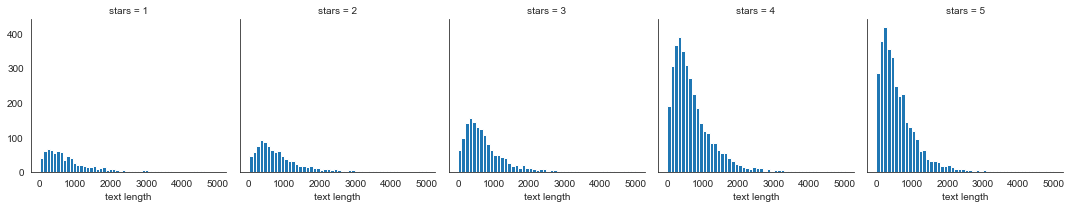

In [13]:
# we want to see the distribution of text lenght based off their star rating
sns.set_style('white')
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length', bins=50)

Let's see if we can visualize this better using a box plot

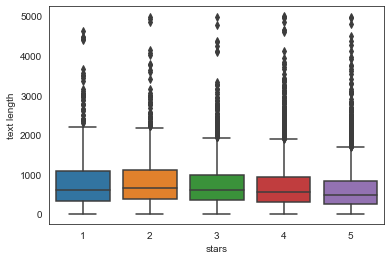

In [14]:
sns.boxplot(x='stars', y='text length', data=yelp)

It seems that text length won't be such a useful features. 
<p> Let's visualize the number of occurences for each type of star

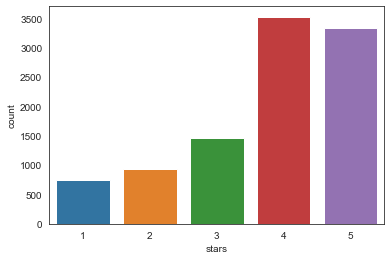

In [15]:
sns.countplot(x='stars',data=yelp)

Based off this information, we can see that the majority of the reviews fall under 4 and 5 stars

In [16]:
# lets create a new dataframe with the mean values of the numerical columns

stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [17]:
# Let's check out the correlation of these columns
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


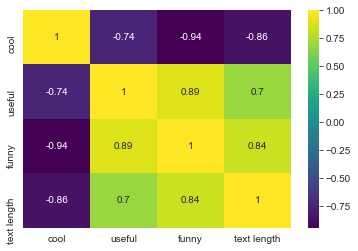

In [19]:
# let's visualize this better with a heatmap
sns.heatmap(stars.corr(),annot=True, cmap='viridis')

We can see that funny is highly correlated to useful and funny to text length <br>
We can also see some negative correlation, but we need more domain knowledge to fully understand this data

<h4>NLP Classification</h4>

For simplicity purposes we will only be using reviews that fall under 1 or 5 stars categories.

In [20]:
# let's create a new DF that reflects this, filter by the conditions
yelp_class = yelp[(yelp['stars']==1) | (yelp['stars']==5)]

In [21]:
# let's take a look
yelp_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  4086 non-null   object
 1   date         4086 non-null   object
 2   review_id    4086 non-null   object
 3   stars        4086 non-null   int64 
 4   text         4086 non-null   object
 5   type         4086 non-null   object
 6   user_id      4086 non-null   object
 7   cool         4086 non-null   int64 
 8   useful       4086 non-null   int64 
 9   funny        4086 non-null   int64 
 10  text length  4086 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 383.1+ KB


We now have less than half of our original entries<br>
This dataset contain 4086 entries <hr>

Before using the review text for our model we need to process it. <br>
This is because we can't pass text directly to NLP Model. We will use Vectorization, which will convert the text into vectors, which will allow the machine model to work with it

For this purporse, we will use Scikit-learn's <a href='https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html'>CountVectorizer </a>
<p><a href='https://www.studytonight.com/post/scikitlearn-countvectorizer-in-nlp#:~:text=CountVectorizer%20tokenizes(tokenization%20means%20breaking,the%20words%20to%20lowercase%2C%20etc.'> CountVectorizer</a> tokenizes the text along with performing very basic preprocessing like removing the punctuation marks, converting all the words to lowercase, etc.


Let's create two objects <br>
X will be the 'text' column of yelp_class <br>
y will be the 'stars' column of yelp_class

In [22]:
X = yelp_class['text']
y = yelp_class['stars']

Importing CountVectorizer and create a CountVectorizer object

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

Using the fit_transform method on the CountVectorizer object and pass in X - the 'text' column

In [24]:
X = cv.fit_transform(X)

<h3>Split Data</h3>

Split data into train and test data

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

<h3>Training the Model</h3>

We will be using the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> which is suitable for discrete features classification 

In [27]:
# Importing MultinomialNB and creating an instance of the estimator
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [28]:
# fit the training data
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

<h3>Evaluating the Model</h3>

In [30]:
# predict method to predict the labels

predictions = nb.predict(X_test)

Let's use a confusion matrix and classification report to visualize this

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[159  69]
 [ 22 976]]


              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



In [38]:
yelp_class['stars'].value_counts()

5    3337
1     749
Name: stars, dtype: int64

<h4>Final Thoughts</h4>
Based off these result, we have around 90+% acurrary, precision and recall for the 5 star category, and the 1 star category wasn't so bad either. <br>

This may be because we have more 5 star text reviews than 1 star reviews. Either way it seems to be pretty good.